In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import math
import matplotlib.pyplot as plt
import numpy as np

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging( logging_level='CRITICAL')

import os
import sys
from pathlib import Path
import IPython.display as ipd
from PySpice.Unit import *
from PySpice.Spice.Parser import SpiceParser
from PySpice.Spice.Netlist import Circuit, SubCircuit, SubCircuitFactory
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Probe.Plot import plot
from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Math import *
from PySpice.Plot.BodeDiagram import bode_diagram
from PySpice.Plot.BodeDiagram import bode_diagram_gain

import schemdraw
import schemdraw.elements as elm
from schemdraw import dsp
from schemdraw import logic

directory_path = Path(os.path.abspath('')).resolve().parent.parent
spice_libraries_path = directory_path.joinpath("lib", "spice")
spice_library = SpiceLibrary(spice_libraries_path)
## set the project directory as directory_path
directory_path = Path(os.path.abspath('')).resolve()

In [2]:
class VoltageDivider(SubCircuitFactory):
    __name__ = 'voltage_divider'
    __nodes__ = ('n1', 'n2', 'n3' )
    __R = 100@u_kΩ;
    def __init__(self, R=100@u_kΩ, w=0.4, name='voltage_divider'):
        self.__name__ = name
        self.__R = R
        super().__init__()
        self.R(1, 'n1', 'n2', R * w)
        self.R(2, 'n2', 'n3', R * (1.0-w) )
        
    def wiper(self, w) :
        if w == 0 :
            self.R1.resistance = self.__R * 0.0000001
            self.R2.resistance = self.__R * 0.9999999
        elif w == 1 :
            self.R1.resistance = self.__R * 0.9999999
            self.R2.resistance = self.__R * 0.0000001
        else :
            self.R1.resistance = self.__R * w
            self.R2.resistance = self.__R * (1.0-w)


# construction

VCA techniques were analyzed in the Ringmodulator article. The goal of this module is it to create a simple and compact VCA. This is a 2-quadrant VCA. The input signal can be bipolar, but the CV input has to be positive. The VCA will not respond to negative CVs. For a 4-quadrant VCA see the produkt module.

The VCA is built in a way that different applications can be configured.

__4 independent VCAs__

path the IN, CV and out of each section.

__

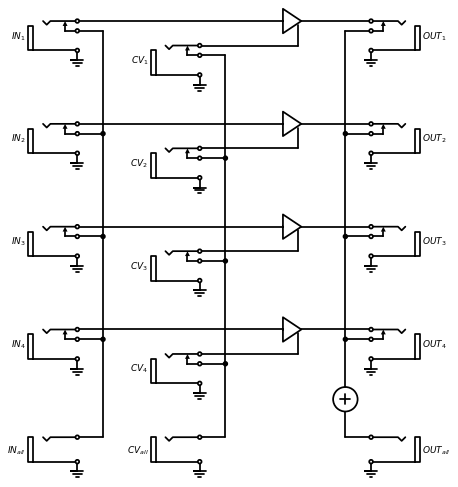

In [39]:
d = schemdraw.Drawing(unit=2.1, inches_per_unit=0.4, lw=1.75, fontsize=9)

inputs = []
cvs = []
outs = []

for i in range(4) :
    O = d.add(elm.AudioJack("left", flip=True, switch=True, xy=[12, -i*2*d.unit], rgtlabel=f'$OUT_{i+1}$'))
    J = d.add(elm.AudioJack(xy=[0, -i*2*d.unit], switch=True, lftlabel=f'$IN_{i+1}$'))
    d.add(elm.Line(xy=J.tip, l=d.unit*4))
    A = d.add(dsp.Amp())
    d.add(elm.Line(tox=O.tip))
    
    C = d.add(elm.AudioJack(xy=[5, -i*2*d.unit-1], switch=True, lftlabel=f'$CV_{i+1}$'))
    d.add(elm.Ground("right", xy=J.sleeve))
    d.add(elm.Ground("right", xy=C.sleeve))
    d.add(elm.Ground("right", xy=O.sleeve))
    inputs.append(J)
    cvs.append(C)
    outs.append(O)

Iall = d.add(elm.AudioJack("right", xy=[0, -8*d.unit], switch=False, lftlabel='$IN_{all}$'))
d.add(elm.Ground("right", xy=Iall.sleeve))
Call = d.add(elm.AudioJack("right", xy=[5, -8*d.unit], switch=False, lftlabel='$CV_{all}$'))
d.add(elm.Ground("right", xy=Call.sleeve))
Oall = d.add(elm.AudioJack("left", flip=True, xy=[12, -8*d.unit], switch=False, rgtlabel='$OUT_{all}$'))
d.add(elm.Ground("right", xy=Oall.sleeve))

for j, k in zip([Iall, Call], [inputs, cvs]) :
    d.add(elm.Line("right", l=d.unit/2, xy=j.tip))
    for i, x in enumerate(reversed(k)) :
        d.add(elm.Line("up", toy=x.tipswitch))
        if i < 3 :
            d.add(elm.Dot())
        d.push()
        d.add(elm.Line("left", tox=x.tipswitch))
        d.pop()
      
d.add(elm.Line("left", l=d.unit/2, xy=Oall.tip))
d.add(elm.Line("up", l=d.unit/2))
d.add(dsp.Sum())
for i, x in enumerate(reversed(outs)) :
    d.add(elm.Line("up", toy=x.tipswitch))
    if i < 3 :
        d.add(elm.Dot())
    d.push()
    d.add(elm.Line("right", tox=x.tipswitch))
    d.pop()

for x in cvs :
    d.add(elm.Line("right", l=4, xy=x.tip))
    d.add(elm.Line("up", l=0.85))

        
d.draw()

The CD4069UB device consist of six CMOS inverter circuits. These devices are intended for all generalpurpose inverter applications where the mediumpower TTL-drive and logic-level-conversion. This device is not ideal for linear amplification, but can be used as such and will add a lot of soft-clipping. Soft-clipping is expected from a valve. This makes this device special for musical usage and can be found in guitar distortion pedals [[2](http://www.runoffgroove.com/ubescreamer.html)] or the wasp filter [[3](https://www.schmitzbits.de/wasp.html)]. 

In [ ]:
kicad_netlist_path = directory_path.joinpath('main', 'main.cir')
parser = SpiceParser(path=str(kicad_netlist_path))

results = []

#for i in np.arange(0, 5, 1) :
circuit = parser.build_circuit(ground=5)
circuit.include(spice_library['TL072c'])
circuit.include(spice_library['D1N4148'])
circuit.include(spice_library['LM13700/NS'])
circuit.include(spice_library['q2n3906'])

circuit.V('1', '+15V', circuit.gnd, 'DC 15')
circuit.V('2', '-15V', circuit.gnd, 'DC -15')
circuit.V('3', '/IN_1', circuit.gnd, 'DC 0 AC 0 Sine(0 5 400)')
circuit.V('4', '/CV_1', circuit.gnd, 'DC 0 AC 0 PULSE(0 5 0 20m 20m 1m 40m)')

#for c in ( VoltageDivider(R=100@u_kΩ, w=0.1, name='POT1'), 
#        VoltageDivider(R=500@u_kΩ, w=0.1, name='POT2') ) :
#    circuit.subcircuit(c)

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
#simulator.options('INTERP')
#simulator.initial_condition("Net-_C5-Pad1_"=0.0)
analysis = simulator.transient(step_time=1@u_us, start_time=0@u_ms, end_time=40@u_ms)


fig_buffer, ax1_buffer = plt.subplots()

ax1_buffer.set_xlabel('time [ms]')
ax1_buffer.set_ylabel('amplitude [V]')
ax1_buffer.plot(u_ms(analysis['/CV_1'].abscissa), analysis['/CV_1'], color='Blue')
ax1_buffer.plot(u_ms(analysis['/OUT_1'].abscissa), analysis['/OUT_1'], color='Red')

ax1_buffer.legend(('CV [V]', 'Vout [V]'), loc=(0.75,0.8))

plt.tight_layout()
plt.show()

the chip should be powered by +5V/GND. With higher voltage the heat dissipation will be to big and the chip will be damaged. the chip is powered on pin 7 and 14 with +5V and Ground. the other pins can be used as amplifier. 

In [ ]:
import sympy as sp
V1, V2, R1, R2 = sp.symbols("V1 V2 R1 R2")
eq1 = sp.Eq(V2, (V1 * R1) / (R1 + R2))
eq1.rhs.evalf(subs={R1: 2.7@u_kOhm, R2: 22@u_kOhm, V1: 15@u_V})

In [ ]:
from IPython.core.display import display, HTML
display(HTML('''
<div class="hero is-medium" style="background: url('{{ '/assets/cmos_buffer_files/tmb_ube_screamer.jpg' | relative_url }}') no-repeat center center; background-size: cover; background-attachment: fixed;">
   <div class="hero-body">
        <div class="content has-text-centered">
        </div>
    </div>
</div>
'''))

# references

https://electricdruid.net/wp-content/uploads/2020/04/EurorackVintageVCA-scaled.jpg